## Examples of quantum algorithms

<p style='text-align: justify;'> In this notebook we are going to present a couple of paradigmatic quantum algorithms and see how they can be implemented in practice in qiskit. You can find many more examples by having a look to this url <a href="https://github.com/Qiskit/qiskit-textbook/">https://github.com/Qiskit/qiskit-textbook/</a> (and also at <a href="http://quantumalgorithmzoo.org/"> http://quantumalgorithmzoo.org/</a>). For didactic purposes, we present here only a very simple oracle-based algorithm (Deutsch's algorithm on $N=2$ qubits) and we leave some exercise for you.

In the end you can have a look at a slightly more advanced one (Quantum Fourier Transform on $N=3$ qubits).

### Quantum parallelism

<p style='text-align: justify;'> A function $\,f:\{0,1\}^n\rightarrow\{0,1\}^m$ can be quantum computed via unitary operations. Usually, two separate qubit registers are used, with $n$ and $m$ qubits respectively. Then, if $x\in\{0,1\}^n$ and $x\in\{0,1\}^m$, what a quantum computer usually does is the following:
$$
\mathrm{U}_f\left|x\right\rangle\left|y\right\rangle = \left|x\right\rangle\left|y\oplus f(x)\right\rangle
$$
where $\left|x\right\rangle$ and $\left|y\right\rangle$ are states in the computational basis of $n$ and $m$ qubits respectively. Notice that the unitary $\mathrm{U}_f$ acts on the Hilbert space of $n+m$ qubits in general. Usually, the second register is initialized in the blank state $\left|y\right\rangle=\left|0\right\rangle^{\otimes m}$. If the state of the first register is prepared in a quantum superposition of all the computational basis states, then we obtain (for simplicity let us first take $n=m=1$)
$$
\mathrm{U}_f\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\left|0\right\rangle \rightarrow \frac{1}{\sqrt{2}}\left(\left|0\right\rangle\left|f(0)\right\rangle+\left|1\right\rangle\left|f(1)\right\rangle\right)
$$
You can easily see that we were able to compute _all_ the possible outputs of $f$ with only one call to the unitary encoding the function. This can be of course generalized to arbitrary $n$ and $m$, and the equally weighted superposition of all the computational basis states can be efficiently obtained by using parallel Hadamard gates:
$$
\mathrm{H}^{\otimes n}\left|0\right\rangle^{\otimes n} = \frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\left|x\right\rangle
$$
Then, as above, we have
$$
\mathrm{U}_f\left(\frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\left|x\right\rangle\right)\left|0\right\rangle^{\otimes m} = \frac{1}{\sqrt{2^n}}\sum_{x\in\{0,1\}^n}\left|x\right\rangle\left|f(x)\right\rangle
$$
Unfortunately, being able to quantum compute all the outputs of $f$ at once does not mean being able to _access_ such outputs efficiently. Indeed, with a direct measure in the computational basis we can only read one of the outputs at a time. How then can this form of quantum parallelism be useful? The answer, as shown below with Deutsch's algorithm, is that it can provide significant advantages whenever we are not interested in particular output values of $f$, but rather in studying the global properties of the function itself.
</p>

### Deutsch's algorithm (1985), $n = m = 1$

<p style='text-align: justify;'> This algorithm belongs to the class of _oracle-based_ examples, and is formulated in terms of a black-box. The problem is the following: given a black-box unitary, the properties and implementation of which we must assume unknown, implementing a function $f: \{0,1\}\rightarrow \{0,1\}$, decide whether $f(0) = f(1)$ or $f(0) \neq f(1)$ using the oracle $\mathrm{U}_f$ only _once_. Notice that such task is impossible classically, since we need at least two calls of the oracle, one for each possible input, to conclude. There are four different possible $f$ functions that the oracle actually implements:
$$
\mathrm{A}: \quad f_1(0) = 0 \, , \, f_1(1) = 1 \quad \text{or} \quad f_2(0) = 1 \, , \, f_2(1) = 0
$$
$$
\mathrm{B}: \quad f_3(0) = 0 \, , \, f_3(1) = 0 \quad \text{or} \quad f_4(0) = 1 \, , \, f_4(1) = 1
$$
The functions labeled with $\mathrm{A}$ have $f(0) \neq f(1)$, while the ones labeled with $\mathrm{B}$ have $f(0) = f(1)$. The task that we have to complete then reduces to distingushing between A-type and B-type functions. The algorithm solving the problem uses two single-qubit registers ($n = m = 1$) and starts from the state
$$
\left|\psi_0\right\rangle = \left|0\right\rangle \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right)
$$
In qiskit, we can prepare it from the standard blank state $\left|0\right\rangle \otimes \left|0\right\rangle$ by applying a $\mathrm{H}$ after a $\mathrm{X}$ on the second qubit:
</p>

## Qiskit Implementation <a id='implementation'></a>


In [1]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

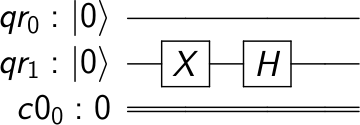

In [2]:
# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(2,name='qr')
crsingle = ClassicalRegister(1)
deutsch = QuantumCircuit(qr,crsingle)

deutsch.x(qr[1])
deutsch.h(qr[1])

deutsch.draw(output='latex')

<p style='text-align: justify;'> Now, in order to profit from the quantum parallelism idea, we create a superposition of computational basis states in the first register by applying a $\mathrm{H}$ gate, obtaining
$$
\left|\psi_0\right\rangle \rightarrow \frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right) \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right)
$$
Notice that this single qubit operation can be performed in parallel with one the previous ones on the other register. The circuit in qiskit becomes:
</p>

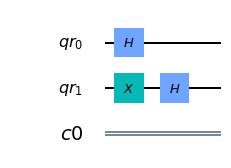

In [3]:
deutsch.h(qr[0])

deutsch.draw(output='mpl')

<p style='text-align: justify;'> We are now ready to let our quantum state go through the black-box unitary $\mathrm{U}_f$ computing the unknown $f$. The action of $\mathrm{U}_f$ goes as presented in the paragraph above, and together with linearity properties of unitary operators, it gives
$$
\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right) \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right) \rightarrow \frac{1}{2} \left[\left|0\right\rangle\left(\left|0\oplus f(0)\right\rangle-\left|1\oplus f(0)\right\rangle\right)+\left|1\right\rangle\left(\left|0\oplus f(1)\right\rangle-\left|1\oplus f(1)\right\rangle\right)\right] \equiv \left| \psi_f\right\rangle
$$
It is easy to see that the terms in $\left| \psi_f\right\rangle$ can be rearranged in the form
$$
\left| \psi_f\right\rangle = \frac{1}{\sqrt{2}} \left((-1)^{f(0)}\left|0\right\rangle+(-1)^{f(1)}\left|1\right\rangle\right) \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right)
$$
One last $\mathrm{H}$ on the first qubit will now give two possible scenarios: indeed, if $f(0) = f(1)$, the final state is (up to a global phase factor)
$$
\left(\mathrm{H}\otimes \mathcal{I}\right) \left| \psi_f\right\rangle = \left|0\right\rangle \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right)
$$
while if $f(0) \neq f(1)$ we have
$$
\left(\mathrm{H}\otimes \mathcal{I}\right) \left| \psi_f\right\rangle = \left|1\right\rangle \otimes \frac{1}{\sqrt{2}}\left(\left|0\right\rangle-\left|1\right\rangle\right)
$$
Finally, a measure of the first register in the computational basis will give the desired outcome: indeed, if we masure the first qubit in $\left| 1\right\rangle$ then we know that $f$ is A-type, while if we see a $\left| 0\right\rangle$ it means that the unknown $f$ is B-type. Notice that we have used $\mathrm{U}_f$ only once.
</p>

<p style='text-align: justify;'> We can complete our example in qiskit by choosing a model for the oracle $\mathrm{U}_f$. You can for example see that for $f = f_1$, a single $\mathrm{CNOT}$ with the first register as control will do the job:
$$
\mathrm{U}_{f_1} = \mathrm{CNOT}(qr_0,qr_1)
$$
If you feel puzzled by the fact that we cannot implement the circuit in practice without knowing _in advance_ the properties of $f$, you may simply consider that the $\mathrm{U}_f$ part of the circuit (the actual black-box) is done for example on a remote server. What we are showing in qiskit is therefore the full story of the quantum state that you and your partner are sharing, with you taking care of the preparation of the state, post-processing and measure, and the other party chosing and performing the $\mathrm{U}_f$ without letting you know the details. What Deutsch's procedure actually tells you is how to prepare a carefully designed state and what to do after you receive it back from the oracle, and it guarantees that you will be able to recover the information about $f$ by exchanging the state only _once_ with the other party. With this in mind, we can complete ansd show the quantum circuit for the case in which the remote server chose $f=f_1$: 
</p>

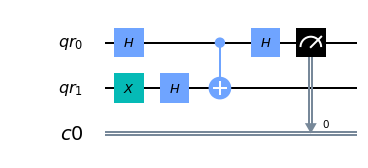

In [4]:
deutsch.cx(qr[0],qr[1])
deutsch.h(qr[0])
deutsch.measure(qr[0],crsingle[0])

deutsch.draw(output='mpl')

<p style='text-align: justify;'> In this particular example, all  the single qubit rotations and the final measure are perfromed by the party that wants to guess the properties of $f$, while the other party performs the $\mathrm{CNOT}$. </p>

### Experiment with Simulators <a id='simulation'></a>

We can run the above circuit on the simulator. 

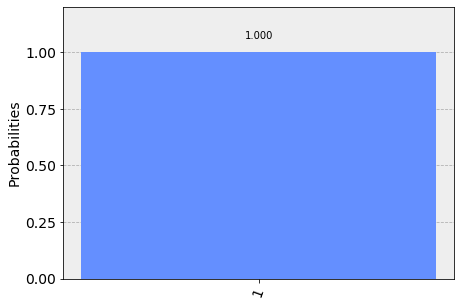

In [5]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(deutsch, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

# Deutsch-Josza Algorithm <a id='djalgorithm'> </a>

In this section, we first introduce the Deutsch-Josza problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run on a simulator and device.

We are given a hidden Boolean function $f$, which takes as as input a string of bits, and returns either $0$ or $1$, that is 
<center>$f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$.

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 

Note that the Deutsch-Josza problem is an $n$-bit extension of the single bit Deutsch problem. 

### Classical Solution <a id='djclassic'> </a>

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function, $f(x)$, is balanced: 
e.g. if we get both $f(0,0,0,... \rightarrow 0)$ and $f(1,0,0,... \rightarrow 1)$ we know the function is balanced as  we have obtained the two different outputs.  

In the worst case, if we continue to see the same output for each input we try, we will have to check exactly $2^{n-1}+1$ inputs to be certain that $f(x)$ is constant: 
e.g. for a $4$-bit string, if we checked $8$ out of the $16$ possible combinations, getting all $0$'s, it is still possible that the $9^\textrm{th}$ input returns a $1$ and $f(x)$ is balanced. Probabilistically, this is a very unlikely event. In fact, if we get the same result continually in succession, we can express the probability that the function is constant as a function of $k$ inputs as:
$$ P_\textrm{constant}(k) = 1 - \frac{1}{2^{k-1}} \qquad \textrm{for } k \leq 2^{n-1}$$
Realistically, we could opt to truncate our classical algorithm early, say if we were over x% confident. But if we want to be 100% confident, we would need to check $2^{n-1}+1$ inputs.

#### Quantum Solution <a id='quantum'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below is the generic circuit for the Deutsh-Josza algorithm.

<img src="images/deutsch_steps.png" width="600">

Now, let's go through the steps of the algorithm:

<ol>
   <li>
        Prepare two quantum registers. The first is an $n$-qubit register initialised to $\vert 0 \rangle$, and the second is a one-qubit register initialised to $\vert 1\rangle$:
        $$\vert \psi_0 \rangle = \vert0\rangle^{\otimes n} \vert 1\rangle$$
   </li>
    
   <li>
        Apply a Hadamard gate to each qubit:
        $$\vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \vert 0\rangle - \vert 1 \rangle$$
   </li>
   
   <li>
        Apply the quantum oracle $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$:
        \begin{aligned}
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned}
        since each $x,f(x)$ is either $0$ or $1$.
   </li>

   <li>
       At this point the second single qubit register may be ignored. Apply a Hadamard gate to each qubit in the first register:
        \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned}
        where $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \ldots \oplus x_{n-1}y_{n-1}$ is the sum of the bitwise product.
   </li>

   <li>
       Measure the first register. Notice that the probability of measuring $\vert 0 \rangle ^{\otimes n} = \lvert \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)} \rvert^2$, which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced. 
   </li>

</ol>

**Why does this work?**

$\qquad$ When the hidden Boolean function is *constant*, the quantum states before and after querying the oracle are the same. The inverse of the Hadamard gate is the Hadamard gate itself. Thus, by Step 4, we essentially reverse Step 2 to obtain the initial quantum state of all-zero at the first register.  

$\qquad$ When the hidden Boolean function is *balanced*, the quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, by Step 4, when reverting the operation, we must end up with a quantum state that is orthogonal to the initial quantum state of all-zero at the first register. This means we should never obtain the all-zero state. 


##### Quantum Oracle

The key to the Deutsch-Josza Algorithm is the implementation of the quantum oracle. 

For a constant function, it is simple:

$\qquad$ 1. if f(x) = 0, then apply the $I$ gate to the qubit in register 2.  
$\qquad$ 2. if f(x) = 1, then apply the $X$ gate to the qubit in register 2.

For a balanced function, it is more complicated:

$\qquad$ There are $2^{n}-1$ different hidden bitstring configurations for an $n$-bit balanced function oracle. These can be defined by one of the bitstrings from $1$ to $2^n-1$ inclusive. Given a particular hidden bitstring, $a$, the oracle is the bitwise product of $x$ and $a$, which is implemented as a multi-qubit f-controlled-NOT gate with the second register, as per Reference [2]. 

### Example  <a id='example'></a>

Let's go through a specfic example for a two bit balanced function with hidden bitstring $a = 3$.

<ol>
    <li> The first register of two qubits is initialized to zero and the second register qubit to one 
    $$\lvert \psi_0 \rangle = \lvert 0 0 \rangle_1 \lvert 1 \rangle_2 $$ 
   </li>
    
   <li> Apply Hadamard on all qubits
    $$\lvert \psi_1 \rangle = \frac{1}{2} \left( \lvert 0 0 \rangle_1 + \lvert 0 1 \rangle_1 + \lvert 1 0 \rangle_1 + \lvert 1 1 \rangle_1 \right) \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right)  $$ 
   </li>
    
   <li> For $a=3$, (11 in binary) the oracle function can be implemented as $\text{Q}_f = CX_{1a}CX_{2a}$, 
       \begin{align*}
            \lvert \psi_2 \rangle =  \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_1 \left( \lvert 0 \oplus 0 \oplus 0 \rangle_2 - \lvert 1 \oplus 0 \oplus 0 \rangle_2 \right) \\
                  + \lvert 0 1 \rangle_1 \left( \lvert 0 \oplus 0 \oplus 1 \rangle_2 - \lvert 1 \oplus 0 \oplus 1 \rangle_2 \right) \\
                  + \lvert 1 0 \rangle_1 \left( \lvert 0 \oplus 1 \oplus 0 \rangle_2 - \lvert 1 \oplus 1 \oplus 0 \rangle_2 \right) \\
                  + \lvert 1 1 \rangle_1 \left( \lvert 0 \oplus 1 \oplus 1 \rangle_2 - \lvert 1 \oplus 1 \oplus 1 \rangle_2 \right) \right]
        \end{align*}
   </li>
    
   Thus
       \begin{aligned}
        \lvert \psi_2 \rangle & = \frac{1}{2\sqrt{2}} \left[ \lvert 0 0 \rangle_1 \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right) - \lvert 0 1 \rangle_1  \left( \lvert 0 \rangle_2 - \lvert  1 \rangle_2 \right) - \lvert 1 0 \rangle_1  \left( \lvert 0  \rangle_2 - \lvert 1 \rangle_2 \right) + \lvert 1 1 \rangle_1  \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right)  \right] \\
        & = \frac{1}{2} \left( \lvert 0 0 \rangle_1 - \lvert 0 1 \rangle_1 - \lvert 1 0 \rangle_1 + \lvert 1 1 \rangle_1 \right) \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right)  \\
        & = \frac{1}{\sqrt{2}} \left( \lvert 0 \rangle_{10} - \lvert 1 \rangle_{10} \right)\frac{1}{\sqrt{2}} \left( \lvert 0 \rangle_{11} - \lvert 1 \rangle_{11} \right)\frac{1}{\sqrt{2}} \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right)
        \end{aligned}
   </li>
    
    
   <li> Apply Hadamard on the first register
        $$ \lvert \psi_3\rangle = \lvert 1 \rangle_{10} \lvert 1 \rangle_{11}  \left( \lvert 0 \rangle_2 - \lvert 1 \rangle_2 \right) 
        $$
   </li>
   
   <li> Measuring the first two qubits will give the non-zero $11$, indicating a balanced function.
   </li>
</ol>


## 3. Qiskit Implementation <a id='implementation'></a>

We now implement the Deutsch-Josza algorithm for the example of a two bit balanced function with hidden bitstring $a = 3$.

In [6]:
# set the length of the $n$-bit string. 
n = 2

# set the oracle, b for balanced, c for constant
oracle = "b"

# if the oracle is balanced, set the hidden bitstring, b
if oracle == "b":
    b = 3 # np.random.randint(1,2**n) uncomment for a random value

# if the oracle is constant, set c = 0 or 1 randomly.
if oracle == "c":
    c = np.random.randint(2)

In [7]:
# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1)
cr = ClassicalRegister(n)

djCircuit = QuantumCircuit(qr, cr)
barriers = True

# Since all qubits are initialized to |0>, we need to flip the second register qubit to the the |1> state
djCircuit.x(qr[n])

# Apply barrier 
if barriers:
    djCircuit.barrier()

# Apply Hadamard gates to all qubits
djCircuit.h(qr)    
    
# Apply barrier 
if barriers:
    djCircuit.barrier()

# Query the oracle 
if oracle == "c": # if the oracle is constant, return c
    if c == 1:
        djCircuit.x(qr[n])
    else:
        djCircuit.iden(qr[n])
else: # otherwise, the oracle is balanced and it returns the inner product of the input with b (non-zero bitstring) 
    for i in range(n):
        if (b & (1 << i)):
            djCircuit.cx(qr[i], qr[n])

# Apply barrier 
if barriers:
    djCircuit.barrier()

# Apply Hadamard gates to the first register after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])

# Measure the first register
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

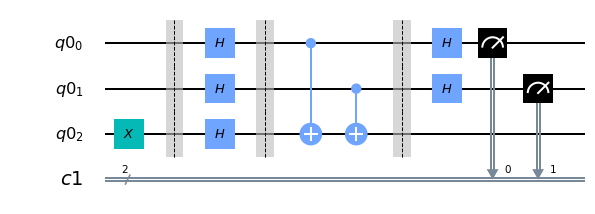

In [8]:
djCircuit.draw(output='mpl')

### Experiment with Simulators <a id='simulation'></a>

We can run the above circuit on the simulator. 

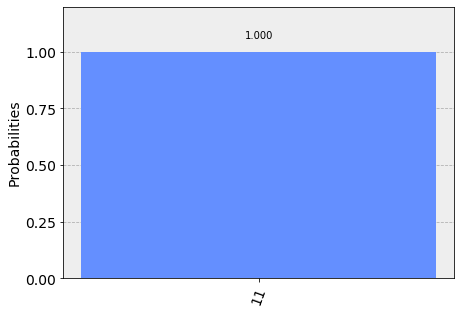

In [9]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(djCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is $11$ as expected.

### Experiment with Real Devices <a id='device'></a>

We can run the circuit on the real device as shown below.

In [12]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [13]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and 
                                   not x.configuration().simulator and x.status().operational==True))

RequestsApiError: 524 Server Error: Origin Time-out for url: https://api.quantum-computing.ibm.com/api/Network/ibm-q/Groups/open/Projects/main/devices/ibmqx2/queue/status?access_token=...

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
job = execute(djCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, most of the results are $11$. The other results are due to errors in the quantum computation. 

## Problems <a id='problems'></a>

1. The above [implementation](#implementation) of Deutsch-Josza is for a balanced function with a two bit input of 3. Modify the implementation for a constant function. Are the results what you expect? Explain.
2. The above [implementation](#implementation) of Deutsch-Josza is for a balanced function with a two bit random input. Modify the implementation for a balanced function with a 4 bit input of 13. Are the results what you expect? Explain.

## _Bonus track_: The Quantum Fourier Transform

<p style='text-align: justify;'> Let $x = \left(x_0,\dots,x_{n-1}\right)$ be a $n$-dimensional vector of complex numbers. We define the Discrete Fourier Transform of $x$ the vector $y$ with components
$$
y_k = \frac{1}{\sqrt{n}}\sum_{j = 0}^{n-1}x_j e^{i2\pi j \frac{k}{n}} \qquad k = 0,\dots,n-1
$$
If we take $j\in\{0,n-1\}$ and we call $\left| j\right\rangle$ a quantum state of $N$ qubits that is a $N$-bit representation  of $j$ on the computational basis (for example, if $j = 4$ and $N = 3$ we have $\left| j\right\rangle = \left| 100\right\rangle \equiv \left| 1\right\rangle\left| 0\right\rangle\left| 0\right\rangle$) we can define the Quantum Fourier Transform (QFT) as the unitary transformation
$$
\left| j\right\rangle \rightarrow \frac{1}{\sqrt{n}}\sum_{k=0}^{n-1}e^{i2\pi j \frac{k}{n}} \left| k\right\rangle
$$
The main advantage of the QFT as compared with the classical counterpart it that it can be efficiently (i.e. with a number of elementary operation polinomial in the size $n$ of the input) implemented on a quantum computer. Without going through all the details of the derivation, which you can for example find in the book by Nielsen and Chuang recommended at the beginning of the algorithms section of this notebook, we present here the general structure of a unitary circuit implementing QFT. After preparing your $N$ qubit register in the input state $\left| j\right\rangle$ by applying for example suitable single qubit rotations (e.g. $\mathrm{X}$ gates), the standard QFT algorithm contains only two types of gates, namely Hadamard single qubit rotations and controlled phase rotations $\mathrm{CPHASE}(\delta)$, and can be constructed using the following procedure:</p>

```
for i = 1 to N do:
    apply H to qubit i in your register
    for k = i+1 to N do:
        l = k-i+1
        apply CPHASE(2*pi*(1/2^l)) with qubit i as target and qubit k as control
```

<p style='text-align: justify;'> Final $\mathrm{SWAP}$ gates are then needed to reverse the order of the output qubits. Here is an example code for QFT in qiskit (without the initial preparation of the input state $\left| j\right\rangle$ and the final $\mathrm{SWAP}$s), in principle valid for any $N$ and $n = 2^N$:</p>

In [ ]:
N = 4
qrQFT = QuantumRegister(N,'qftr')
QFT = QuantumCircuit(qrQFT)

for i in range(N):
    QFT.h(qrQFT[i])
    for k in range(i+1,N):
        l = k-i+1
        QFT.cu1(2*math.pi/(2**l),qrQFT[k],qrQFT[i])

QFT.draw(output='mpl')

## 5. References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

In [ ]:
import qiskit
qiskit.__qiskit_version__